## Chat Message Memory
- We need to store the historical chat messages in a efficient way
- It wraps another Runnable and manages the chat message history for it.
- Specifically, it loads previous messages in the conversation BEFORE passing it to the Runnable, and it saves the generated response as a message AFTER calling the runnable.
-  This class also enables multiple conversations by saving each conversation with a session_id
- it then expects a `session_id` to be passed in the config when calling the runnable, and uses that to look up the relevant conversation history

In [1]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())


True

In [2]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")


![Screenshot 2025-07-20 at 1.12.55 PM.png](<attachment:Screenshot 2025-07-20 at 1.12.55 PM.png>)
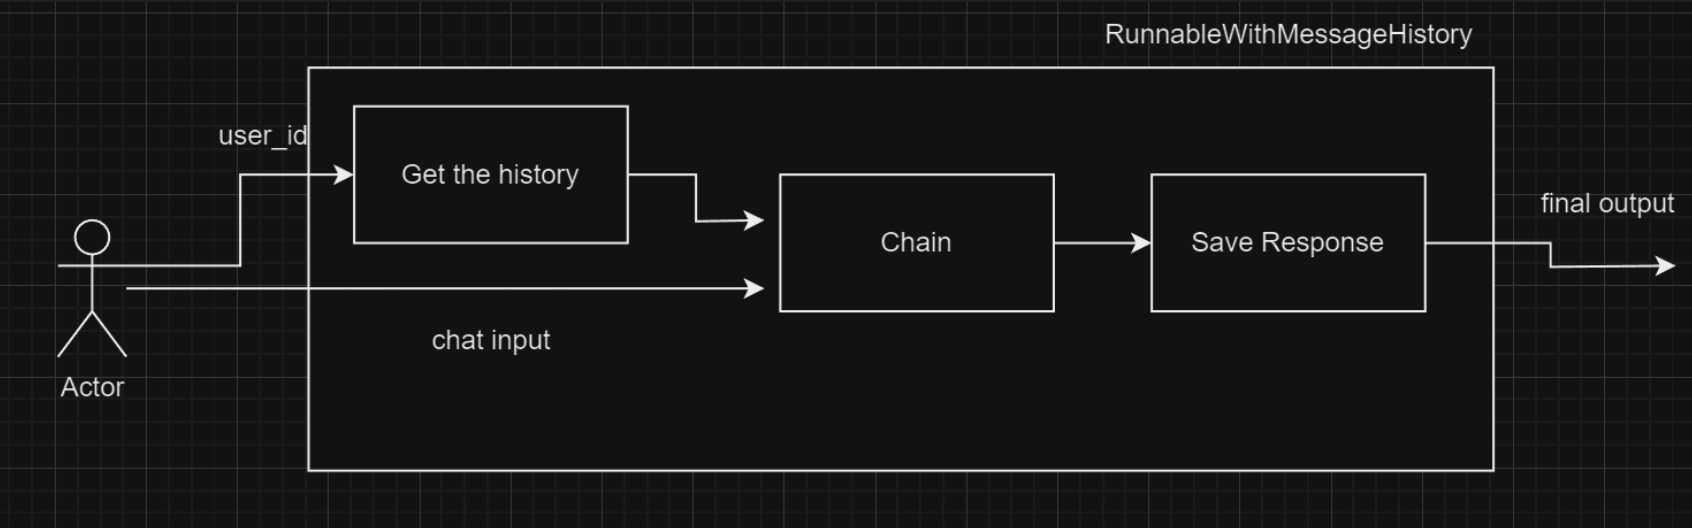

In [3]:


from langchain_core.prompts import (
                                        SystemMessagePromptTemplate,
                                        HumanMessagePromptTemplate,
                                        ChatPromptTemplate
                                        )

from langchain_core.output_parsers import StrOutputParser


template = ChatPromptTemplate.from_template("{prompt}")
chain = template | llm | StrOutputParser()

about = "My name is Prashant Nair. I work for VNex Soutions."
chain.invoke({'prompt': about})


"Hello, Prashant Nair! It's great to meet you. How can I assist you today?"

In [4]:
prompt = "What is my name?"
chain.invoke({'prompt': prompt})

"I'm sorry, but I don't have access to personal information about you unless you share it with me. How can I assist you today?"

### Runnable With Message History

In order to properly set this up there are two main things to consider:
- How to store and load messages?
- What is the underlying Runnable you are wrapping and what are its inputs/outputs?


In [5]:
from langchain_core.prompts import (
                                        SystemMessagePromptTemplate,
                                        HumanMessagePromptTemplate,
                                        ChatPromptTemplate
                                        )

from langchain_core.output_parsers import StrOutputParser

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_community.chat_message_histories import SQLChatMessageHistory

In [6]:
def get_session_history(session_id):
    return SQLChatMessageHistory(session_id, "sqlite:///chat_history.db")

In [7]:
runnable_with_history = RunnableWithMessageHistory(chain, get_session_history)

In [8]:
user_id = 'p_nair'
history = get_session_history(user_id)

history.get_messages()

/var/folders/cc/_kcvjw313pl6kbf8c3bdtnyc0000gn/T/ipykernel_86378/2621192923.py:2: LangChainDeprecationWarning: `connection_string` was deprecated in LangChain 0.2.2 and will be removed in 1.0. Use connection instead.
  history = get_session_history(user_id)


[]

In [ ]:
### Clear the chat history
# history.clear()

In [10]:
about

'My name is Prashant Nair. I work for VNex Soutions.'

In [11]:
runnable_with_history.invoke([HumanMessage(content=about)],
                             config={'configurable': {'session_id': user_id}})

"Hello Prashant Nair! It's great to meet you. How can I assist you today?"

In [12]:
runnable_with_history.invoke([HumanMessage(content="whats my name?")],
                             config={'configurable': {'session_id': user_id}})

'Your name is Prashant Nair. How can I assist you further?'

### Message History with Dictionary Like Inputs

In [13]:
from langchain_core.prompts import (
                                        SystemMessagePromptTemplate,
                                        HumanMessagePromptTemplate,
                                        ChatPromptTemplate,
                                        MessagesPlaceholder
                                        )

from langchain_core.output_parsers import StrOutputParser

from langchain_core.messages import HumanMessage, SystemMessage

In [14]:
system = SystemMessagePromptTemplate.from_template("You are helpful assistant.")
human = HumanMessagePromptTemplate.from_template("{input}")

messages = [system, MessagesPlaceholder(variable_name='history'), human]

prompt = ChatPromptTemplate(messages=messages)

chain = prompt | llm | StrOutputParser()


runnable_with_history = RunnableWithMessageHistory(chain, get_session_history, 
                                                   input_messages_key='input', 
                                                   history_messages_key='history')



In [15]:
def chat_with_llm(session_id, input):
    output = runnable_with_history.invoke(
        {'input': input},
        config={'configurable': {'session_id': session_id}}
    )

    return output

In [16]:
user_id = "vihaan"
chat_with_llm(user_id, about)

"Hello, Prashant Nair! It's great to meet you. How can I assist you today?"

In [17]:
user_id = "vihaan"
chat_with_llm(user_id, about)

"Hello again, Prashant Nair! If there's anything specific you'd like to discuss or any questions you have about your work at VNex Solutions, feel free to let me know!"

In [18]:
# User A
output_a1 = runnable_with_history.invoke(
    {"input": "Hi, I'm Alice."},
    config={"configurable": {"session_id": "alice-session"}}
)
output_a2 = runnable_with_history.invoke(
    {"input": "What's the weather?"},
    config={"configurable": {"session_id": "alice-session"}}
)

# User B
output_b1 = runnable_with_history.invoke(
    {"input": "Hi, I'm Bob."},
    config={"configurable": {"session_id": "bob-session"}}
)
output_b2 = runnable_with_history.invoke(
    {"input": "Tell me a joke."},
    config={"configurable": {"session_id": "bob-session"}}
)


In [19]:
runnable_with_history.invoke({"input": "Tell me my name"},
    config={"configurable": {"session_id": "bob-session"}})

'Your name is Bob! How can I help you today, Bob?'

In [20]:
runnable_with_history.invoke({"input": "Tell me my name"},
    config={"configurable": {"session_id": "alice-session"}})

'Your name is Alice! How can I assist you further, Alice?'